A large amount of the outputs of this notebook are plotly.express maps which could not be saved in the notebook, it is necessary to run the notebook to see them

# 1. Motivation

The goal of our project was to analyze the effects, both positive and negative, of the green gentrification in New York City. To do so we are using several datasets :

>* Air_Quality.csv : We chose this dataset to be able to see if all the green projects implemented have a real effect on the air pollution.

>* ARCHIVED_-_NYC_Greenthumb_Community_Gardens.csv : This dataset is used to correlate green projects and poverty as well as to show the mpact of such projects on the sense of community in the neighbourhood they are implemented in.

>* communitydistrictsny.geojson.json : This dataset contains geographic data necessary to be able to create maps divided in neighbourhoods.

>* Concentrated Poverty.csv : We chose this dataset, to be able to analyse the correlation and effect of green gentrification and Concentrated Poverty in NYC.

>* DOB_Sustainability_Compliance_Map__Local_Law_33.csv : This dataset contains data about NYC building, and especially Energy Ratings of buildings. The goal was to link Energy Ratings with social data like green projects or poverty.

>* GI_assets_publicMap_construct.csv : 

>* Greenstreets.shp : This file contains the shape of greenstreets in NYC, the goal is to correlate it with gentrification and social data like Poverty or a Demographics like racial mapping.

>* nynta.csv : This file was used to convert location to neighbourhoods.

>* race_composition_data.csv : We chose this dataset, to be able to link it to Gentrification and Poverty.

>* income_distribution_data.csv, median_rent_data.csv : We chose these datasets to compare different districts and the visible effects of gentrification on them.

>* Borough Boundaries.geojson : The goal of this dataset is to visualize the different Boroughs in New York, to facilitate the description of the maps.

# 2. Basic stats

Write about your choices in data cleaning and preprocessing

Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In [1]:
# Importing the necessary packages

import pandas as pd
import numpy as np
import json
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
sns.set()

### Mapping the Boroughs

In [ ]:
with open('Borough Boundaries.geojson') as json_data:
    newyork_bg = json.load(json_data)
    
# Update the content loaded from the json file
for feature in newyork_bg['features']:
    feature['id'] = feature['properties']['boro_code']

data_borough = pd.DataFrame({'code' : [1,2,3,4,5], 'name' : ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']})
col_b = [px.colors.sequential.matter_r[k] for k in [0,3,6,8,10]]
fig = px.choropleth_mapbox(data_borough, geojson=newyork_bg, locations='code', color = 'name',
                           color_discrete_sequence=col_b,
                           mapbox_style="carto-positron",
                           zoom=8, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.9,
                           hover_data=['code', 'name'],
                           labels={
                               'code': 'District code',
                               'name': 'District name',
                           },
                          title="New York Boroughs" 
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [2]:
# Reading the file with the necessary data to be able to plot NYC Maps subdivised into neighbourhoods.

with open('communitydistrictsny.geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
# Update the content loaded from the json file
for feature in newyork_data['features']:
    feature['id'] = feature['properties']['borocd']

### Air Quality

In [ ]:
#Reading the file
df_air = pd.read_csv('Air_Quality.csv')

def is_annual (tp) :
    return tp.startswith('Annual')

def to_year (tp) :
    return int(tp[-4:])

# Keeping only the rows corresponding to annual average
df_air['is_annual'] = df_air['Time Period'].apply(is_annual)
df_air_annual = df_air[df_air.is_annual]
df_air_annual['Year'] = df_air_annual['Time Period'].apply(to_year)

# To analyse the evolution we will plot the maps corresponding to the first and the last year of the recordings
data_air_2020 = df_air_annual[(df_air_annual.Year == 2020) & (df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]
data_air_2009 = df_air_annual[(df_air_annual.Year == 2009)&(df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]

# Plot the map for 2020
fig = px.choropleth_mapbox(data_air_2020, geojson=newyork_data, locations='Geo Join ID', color='Data Value',
                           color_continuous_scale="matter",
                           range_color=(5.3, 7),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geo Join ID', 'Data Value', 'Geo Place Name'],
                           labels={
                               'Geo Join ID': 'District code',
                               'Data Value': 'Fine Particulate Matter (PM2.5)',
                               'Geo Place Name': 'District name',
                           },
                          title="Average Air Pollution in NYC in 2020" 
                          )

fig.show()

In [ ]:
# Plot the map for 2009
fig = px.choropleth_mapbox(data_air_2009, geojson=newyork_data, locations='Geo Join ID', color='Data Value',
                           color_continuous_scale="matter",
                           range_color=(8, 15),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geo Join ID', 'Data Value', 'Geo Place Name'],
                           labels={
                               'Geo Join ID': 'District code',
                               'Data Value': 'Fine Particulate Matter (PM2.5)',
                               'Geo Place Name': 'District name',
                           },
                           title="Average Air Pollution in NYC in 2009"
                          )
fig.show()

We can see that pollution was indeed reduced in the whole city. The peak of pollution shifted from western Brooklyn to the Bronx and the Northern fronteer between Brooklyn and Queens.

### Greenstreets

In [ ]:
# Reading the file
df_gs = gpd.read_file('Greenstreets.shp')

# Since the precision of the map doesn't allow to plot the shapes of the greenstreets we will plot their centroid
df_gs['centroid'] = df_gs.centroid
lat = []
lon = []

for _, r in df_gs.iterrows():
    lat += [r['centroid'].y]
    lon += [r['centroid'].x]
    
df_gs['latitude'] = lat
df_gs['longitude'] = lon

# Plot the map
fig = px.choropleth_mapbox(data_air_2020, geojson=newyork_data, locations='Geo Join ID', color='Data Value',
                           color_continuous_scale="matter",
                           range_color=(5.33, 7),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geo Join ID', 'Data Value', 'Geo Place Name'],
                           labels={
                               'Geo Join ID': 'District code',
                               'Data Value': 'Annual Average Air Pollution',
                               'Geo Place Name': 'District name',
                           },
                           title="Average Air Pollution in NYC in 2020 and Greenstreets"
                          )

fig2 = px.scatter_mapbox(df_gs, lon="longitude", lat="latitude", color_discrete_sequence=['LightGreen'], size = [1]*len(df_gs), size_max = 3 )
fig.add_trace(fig2.data[0])

fig.layout.coloraxis2 = fig2.layout.coloraxis

fig.update_geos(fitbounds="locations", visible=False)
fig.layout.coloraxis2.colorbar.x = -0.2
fig.show()

Greenstreets seem to be scattered all around the city but they are a bit more concentrated in Manhattan, the most polluted area of Brooklyn, Queens and in the Bronx.

#### Poverty data

In [6]:
data = pd.read_csv("Concentrated Poverty.csv", skiprows=5)

# Extract data from the whole city
NYC_data = data[(data.Location == "New York City")].sort_values(["DataFormat", "TimeFrame"])
NYC_data_percent = NYC_data[NYC_data.DataFormat == "Percent"]
NYC_data = NYC_data[NYC_data.DataFormat == "Number"]
NYC_data['Percent'] = list(NYC_data_percent.Data)
NYC_data

# Extract data for each borough
borough_data = data[data.Location.isin(["Brooklyn", "Queens", "Bronx", "Manhattan", "Staten Island"])].sort_values(["DataFormat", "Location", "TimeFrame"])
borough_data_percent = borough_data[borough_data.DataFormat == "Percent"]
borough_data = borough_data[borough_data.DataFormat == "Number"]
borough_data["Percent"] = list(borough_data_percent.Data)
borough_data

# Extract data for each neighbourhood
neighbour_data = data[~data.Location.isin(["New York City", "Brooklyn", "Queens", "Bronx", "Manhattan", "Staten Island"])].sort_values(["DataFormat", "Location", "TimeFrame"])
neighbour_data_percent = neighbour_data[neighbour_data.DataFormat == "Percent"]
neighbour_data = neighbour_data[neighbour_data.DataFormat == "Number"]
neighbour_data["Percent"] = list(neighbour_data_percent.Data)
neighbour_data

# Extract neighbourhood data for the year 2020
data_2020 = neighbour_data[neighbour_data.TimeFrame == 2020]

# Extract neighbourhood data for the year 2010
data_2010 = neighbour_data[neighbour_data.TimeFrame == 2010]

In [ ]:
# Get coordinates of neighbourhoods of NYC
# Source : https://cocl.us/new_york_dataset
with open('communitydistrictsny.geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
# Update the content loaded from the json file
for feature in newyork_data['features']:
    feature['id'] = feature['properties']['borocd']

max_val = 0.4 #data_2020.Percent.max()
min_val = 0.0 #data_2020.Percent.min()

# Print the map
fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(min_val, max_val),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           title = "Concentrated poverty by neibourhood in NYC in 2020",
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Prop of concentrated poverty',
                               'Location': 'District name',
                           }
                          )
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

fig2 = px.choropleth_mapbox(data_2010, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(min_val, max_val),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Proportion of concentrated poverty',
                               'Location': 'District name',
                           },
                           title="Concentrated poverty by neibourhood in NYC in 2010"
                          )
fig2.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig2.show()

We can see that Poverty decreased since 2010, but the poorest areas have not shifted. They are mostly concentrated in the Bronx and the fronteer between Queens and Brooklynn. These areas seem to overlap quite well with the current most polluted areas.

### Racial Demographics

In [8]:
# Reading the file and keep the neighbourhood data
df_r = pd.read_csv('race_composition_data.csv')
df_r = df_r[df_r.Level == 'Community District']

def to_float (x) :
    return float(x[:-1])

# We are only keeping the latest rates 
df_r['hisp_rate'] = df_r['pop_hispanic_pct'].apply(to_float)
df_r['aa_rate'] = df_r['pop_non_hispanic_black_pct'].apply(to_float)
df_r['as_rate'] = df_r['pop_non_hispanic_asian_pct'].apply(to_float)

dico = {'BX':'2', 'BK':'3', 'MN':'1', 'QN':'4', 'SI':'5'}

def geo_to_code (x) :
    return dico[x.split(' ')[0]] + x.split(' ')[1]

df_r['Code'] = df_r.Geography.apply(geo_to_code)

In [ ]:
# Print the map
fig = px.choropleth_mapbox(df_r, geojson=newyork_data, locations='Code', color='aa_rate',
                           color_continuous_scale="matter",
                           range_color=(0, 85),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geography', 'aa_rate', 'Name'],
                           labels={
                               'Geography': 'District code',
                               'aa_rate': 'Percentage of African American Population',
                               'Name': 'District name',
                           },
                           title = 'Percentage of African American Population in 2020'
                          )


fig.show()

In [ ]:
# Print the map
fig = px.choropleth_mapbox(df_r, geojson=newyork_data, locations='Code', color='hisp_rate',
                           color_continuous_scale="matter",
                           range_color=(0, 85),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geography', 'hisp_rate', 'Name'],
                           labels={
                               'Geography': 'District code',
                               'hisp_rate': 'Percentage of Hispanic Population',
                               'Name': 'District name',
                           },
                           title = 'Percentage of Hispanic Population in 2020'
                          )

fig.show()

The Hispano-American population is mostly concentrated in the Bronx, which matches both the peak of Poverty and of Air pollution.

In [ ]:
fig = px.choropleth_mapbox(df_r, geojson=newyork_data, locations='Code', color='as_rate',
                           color_continuous_scale="matter",
                           range_color=(0, 85),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geography', 'as_rate', 'Name'],
                           labels={
                               'Geography': 'District code',
                               'as_rate': 'Percentage of Asian American Population',
                               'Name': 'District name',
                           },
                           title = 'Percentage of Asian American Population in 2020'
                          )
fig.show()

The areas in which Asian-American population is mostly concentrated do not seem to overlap with the previously displayed maps. Therefore, we will overlook this data in the rest of our analysis.

#### Green infrastructure dataset

In [12]:
# Load the GI dataset and extract lattitude and longitude from the the_geom attribute
green_infra = pd.read_csv('GI_assets_publicMap_construct.csv')
green_infra["Latitude"] = green_infra["the_geom"].apply(lambda point: float(point.split()[2][:-1]))
green_infra["Longitude"] = green_infra["the_geom"].apply(lambda point: float(point.split()[1][1:]))

In [ ]:
fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title= "Poverty and green infrastructures data"
                          )
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig2 = px.scatter_mapbox(green_infra, lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra), size_max = 3)
fig.add_trace(fig2.data[0])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

This map shows that, even though there are green infrastructures in the entire city, they are mostly located in Queens and Brooklyn. There are also present in the Bronx, but are significantly less concentrated.

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


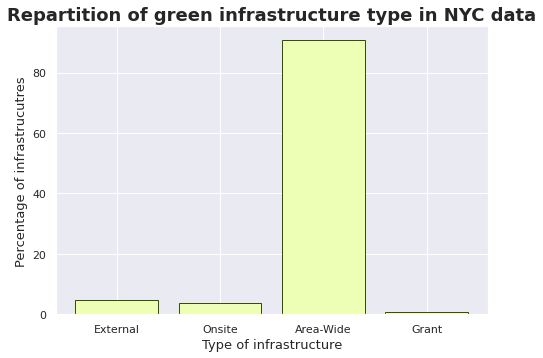

25.2% infrastructures involve trees


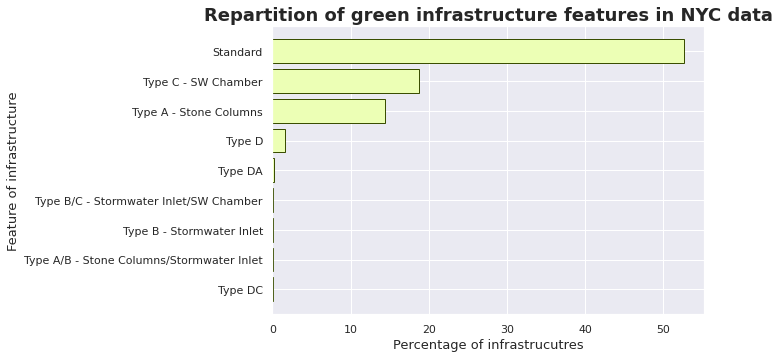

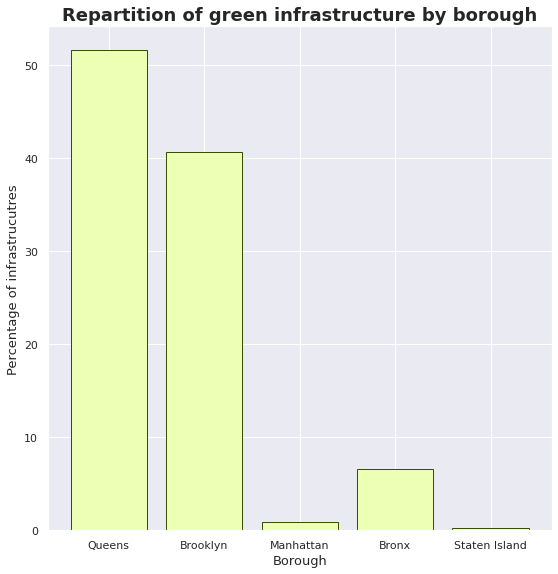

In [14]:
n_infra = green_infra.shape[0]

types = green_infra.Project_Ty.unique()
counts = []
for tp in types:
    counts.append(green_infra[green_infra['Project_Ty'] == tp].shape[0]/n_infra*100)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(types, counts, color='#ecffb5', edgecolor='#3a4e01')
ax.set_xlabel('Type of infrastructure', fontsize = 13)
ax.set_ylabel('Percentage of infrastrucutres', fontsize = 13)
ax.set_title('Repartition of green infrastructure type in NYC data',
 fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.show()

features = green_infra.GI_Feature.unique()
features_clean = [x for x in features if x == x]
trees = green_infra.Tree_Commo.unique()

no_trees = green_infra[green_infra.Tree_Commo.isna()]
prop_no_trees = no_trees.shape[0]/n_infra*100
print('{:2.1f}% infrastructures involve trees'.format(100 - prop_no_trees))

counts_features = []
for feat in features_clean:
    counts_features.append(green_infra[green_infra.GI_Feature == feat].shape[0]/n_infra*100)
    
xy = sorted(zip(counts_features, features_clean))
y = [el[0] for el in xy]
x = [el[1] for el in xy]
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(x, y, color='#ecffb5', edgecolor='#3a4e01')
ax.set_ylabel('Feature of infrastructure', fontsize = 13)
ax.set_xlabel('Percentage of infrastrucutres', fontsize = 13)
ax.set_title('Repartition of green infrastructure features in NYC data',
 fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.show()

bor = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
counts_bor = []
for borough in bor:
    counts_bor.append(green_infra[green_infra.Borough == borough].shape[0]/n_infra*100)

plt.rcParams["figure.figsize"] = [7, 7]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(bor, counts_bor, color='#ecffb5', edgecolor='#3a4e01')
ax.set_xlabel('Borough', fontsize = 13)
ax.set_ylabel('Percentage of infrastrucutres', fontsize = 13)
ax.set_title('Repartition of green infrastructure by borough',
 fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.show()

From these graphs we observe that the vast majority of Green Infrastructure are of the type 'Area-wide'. Most of them are Standard, which does not give much information, it could be bioswales or green roofs for example. Then the two most represented categories are StormWater Chambers and Stone Columns.
The large majority of green infrastructure is located in Queens and Brooklyn, and then, in a lesser extent, in the Bronx.

# 3. Data Analysis

Describe your data analysis and explain what you've learned about the dataset. *If relevant, talk about your machine-learning.

### Air Quality

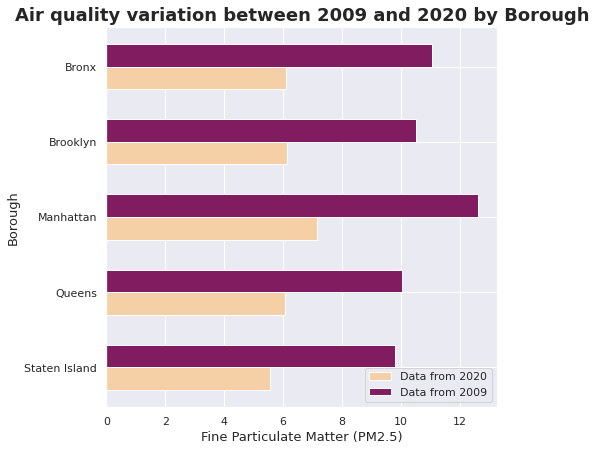

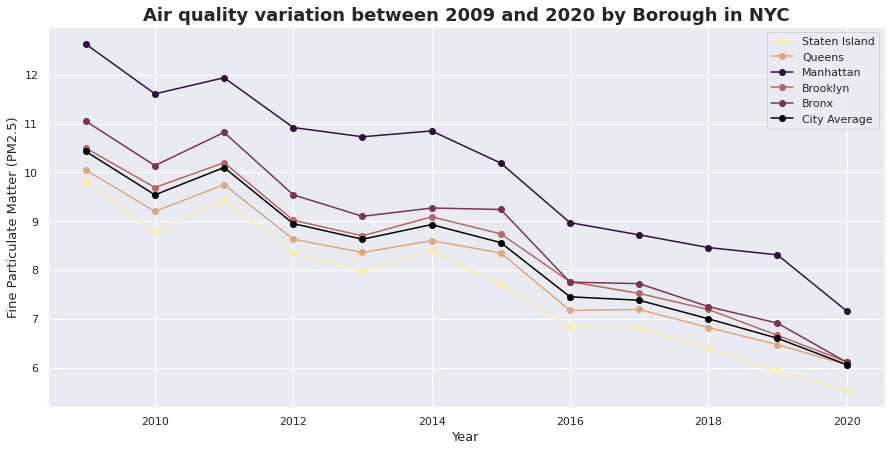

In [15]:
data_air_2020n = data_air_2020[data_air_2020['Geo Type Name'] == 'Borough']
data_air_2009n = data_air_2009[data_air_2009['Geo Type Name'] == 'Borough']

# Ploting the variation of Air Pollution by Borough
plt.rcParams["figure.figsize"] = [7, 7]
plt.figure()
plt.barh(data_air_2020n['Geo Place Name'], data_air_2020n['Data Value'], align = 'edge', height = -0.3, color = '#f5cfa5', label = 'Data from 2020')
plt.barh(data_air_2009n['Geo Place Name'], data_air_2009n['Data Value'], align = 'edge', height = 0.3, color = '#821c61', label = 'Data from 2009')
plt.legend()
plt.ylabel('Borough', fontsize = 13)
plt.xlabel('Fine Particulate Matter (PM2.5)', fontsize = 13)
plt.title('Air quality variation between 2009 and 2020 by Borough', fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.show()

col_dic = {'Manhattan' : '#310f3e', 'Bronx' : '#783453', 'Brooklyn' : '#b36865', 'Queens' : '#dfa77f', 'Staten Island' : '#fdebae'}

# Ploting the Timeseries of Average Air Pollution
plt.rcParams["figure.figsize"] = [15, 7]
plt.figure()
for b in data_air_2020n['Geo Place Name'] : 
    plt.plot(df_air_annual[(df_air_annual['Geo Place Name'] == b)& (df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]['Year'], df_air_annual[(df_air_annual['Geo Place Name'] == b) & (df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]['Data Value'], 'o-', color = col_dic[b], label = b)

plt.plot(df_air_annual[(df_air_annual['Geo Place Name'] == 'New York City')& (df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]['Year'], df_air_annual[(df_air_annual['Geo Place Name'] == 'New York City') & (df_air_annual.Name == 'Fine Particulate Matter (PM2.5)')]['Data Value'], 'o-', color = 'black', label = 'City Average')   
plt.ylabel('Fine Particulate Matter (PM2.5)', fontsize = 13)
plt.xlabel('Year', fontsize = 13)
plt.title('Air quality variation between 2009 and 2020 by Borough in NYC', fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.legend()
plt.show()


We can see that indeed Air Pollution decreased and, even aggregating the data into Borough Manhattan is the most polluted in average, due to the high urbanization of this Borough. But the Bronx is the second most polluted, which corresponds to the observations made earlier.

### Concentrated Poverty

In [16]:
data_evol = data_2020.copy()
diff = [(list(data_2020.Percent)[i] - list(data_2010.Percent)[i]) for i in range(len(list(data_2020.Percent)))]

def evol(data1, data2):
    ev = data1 - data2
    if data2 != 0:
        ev /= data2
        ev *=100
    return ev

def list_evol(list1, list2):
    return [evol(list1[i], list2[i]) for i in range(len(list1))]

diff_2 = list_evol(list(data_2020.Percent), list(data_2010.Percent))

data_evol['Percent'] = diff_2
data_evol['Percent2'] = diff

In [ ]:
max_ev = np.maximum(abs(data_evol.Percent.min()), abs(data_evol.Percent.max()))
min_ev = np.minimum(abs(data_evol.Percent.min()), abs(data_evol.Percent.max()))

# Print the map
fig = px.choropleth_mapbox(data_evol, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(-min_ev, min_ev),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title="Gentrification in NYC (proportion changed)"
                          )
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

# Print the map
fig2 = px.choropleth_mapbox(data_evol, geojson=newyork_data, locations='Fips', color='Percent2',
                           color_continuous_scale="matter",
                           range_color=(-0.1, 0.1),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent2': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title="Gentrification in NYC (brute difference)"
                          )
fig2.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig2.update_geos(fitbounds="locations", visible=False)
fig2.show()

As could be expected, the poorest areas met a decreased of concentrated poverty.

### Racial Demographics

In [ ]:
df_r['ha_rate'] = df_r['aa_rate']+df_r['hisp_rate']

# Print the map
fig = px.choropleth_mapbox(df_r, geojson=newyork_data, locations='Code', color='ha_rate',
                           color_continuous_scale="matter",
                           range_color=(0, 100),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Geography', 'ha_rate', 'Name'],
                           labels={
                               'Geography': 'District code',
                               'ha_rate': 'Percentage of AA and HA Pop',
                               'Name': 'District name',
                           },
                           title = 'Percentage of African American and Hispanic American Population in 2020'
                          )

fig.show()

We can see that this map is strongly correlated to the Concentrated Poverty one.

#### Green infrastructures data

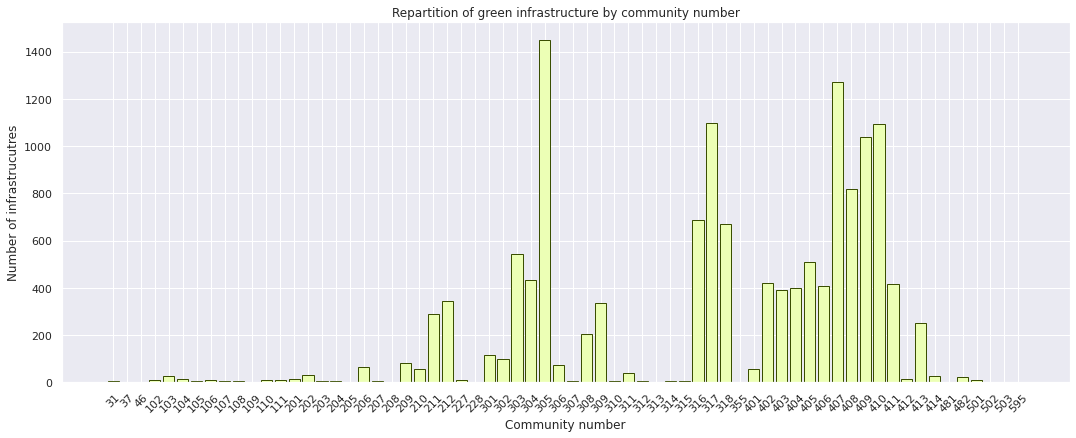

In [19]:
com = sorted(green_infra.Community.unique())

counts_com = []
for commun in com:
    counts_com.append(green_infra[green_infra.Community == commun].shape[0])

fig = plt.figure(figsize=(14,5))
ax = fig.add_axes([0,0,1,1])
ax.bar([str(int(c)) for c in com[:-1]], counts_com[:-1], color='#ecffb5', edgecolor='#3a4e01')
ax.set_xlabel('Community number')
ax.set_ylabel('Number of infrastrucutres')
ax.set_title('Repartition of green infrastructure by community number')
plt.xticks(rotation=45)
plt.show()

Here again, we can see that most green infrastructures are located in 300 and 400 community number (Brooklyn and Queens), but they are not equally distributed in the Boroughs.

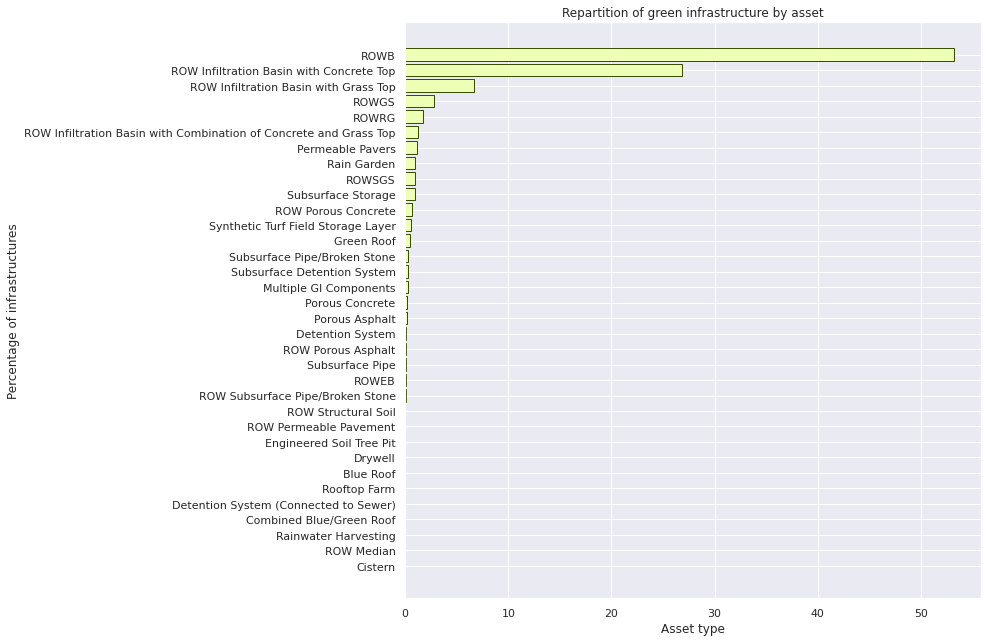

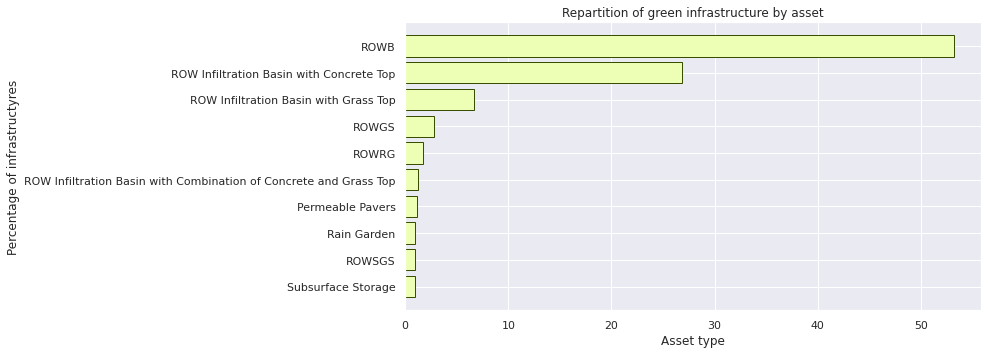

In [20]:
assets = green_infra.Asset_Type.unique()

counts_assets = []
for ass in assets:
    counts_assets.append(green_infra[green_infra.Asset_Type == ass].shape[0]/n_infra*100)

xy = sorted(zip(counts_assets, assets))
y = [el[0] for el in xy]
x = [el[1] for el in xy]

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.barh(x, y, color='#ecffb5', edgecolor='#3a4e01')
ax.set_xlabel('Asset type')
ax.set_ylabel('Percentage of infrastructures')
ax.set_title('Repartition of green infrastructure by asset')
plt.show()

end = len(assets)

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.barh(x[end-10:end], y[end-10:end], color='#ecffb5', edgecolor='#3a4e01')
ax.set_xlabel('Asset type')
ax.set_ylabel('Percentage of infrastructyres')
ax.set_title('Repartition of green infrastructure by asset')
plt.show()

The five most represented assets are Right Of Ways, which are public spaces allocated for roads and sidewalks.

**Maps with points for the 10 most important (in proportion) types of infrastructures :**

In [ ]:
for asset in x[end-2:end]:
    fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title = f'Maps of GI of asset {asset}'
                          )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig2 = px.scatter_mapbox(green_infra[green_infra.Asset_Type == asset], lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra[green_infra.Asset_Type == asset]), size_max = 3)
    fig.add_trace(fig2.data[0])
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

In [ ]:
for asset in x[end-4:end-2]:
    fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title = f'Maps of GI of asset {asset}'
                          )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig2 = px.scatter_mapbox(green_infra[green_infra.Asset_Type == asset], lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra[green_infra.Asset_Type == asset]), size_max = 3)
    fig.add_trace(fig2.data[0])
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

In [ ]:
for asset in x[end-6:end-4]:
    fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title = f'Maps of GI of asset {asset}'
                          )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig2 = px.scatter_mapbox(green_infra[green_infra.Asset_Type == asset], lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra[green_infra.Asset_Type == asset]), size_max = 3)
    fig.add_trace(fig2.data[0])
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

In [ ]:
for asset in x[end-8:end-6]:
    fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title = f'Maps of GI of asset {asset}'
                          )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig2 = px.scatter_mapbox(green_infra[green_infra.Asset_Type == asset], lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra[green_infra.Asset_Type == asset]), size_max = 3)
    fig.add_trace(fig2.data[0])
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

In [ ]:
for asset in x[end-10:end-8]:
    fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(0.0, 0.4),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Evolution of percentage of concentrated poverty',
                               'Location': 'District name',
                           },
                           title = f'Maps of GI of asset {asset}'
                          )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig2 = px.scatter_mapbox(green_infra[green_infra.Asset_Type == asset], lon="Longitude", lat="Latitude",
                         range_color=(0, 100), opacity = 1, color_discrete_sequence=['LightGreen'], 
                         size = [1]*len(green_infra[green_infra.Asset_Type == asset]), size_max = 3)
    fig.add_trace(fig2.data[0])
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

We can see that each type of Green Infrastructure is located differently. As most of them are ROW, it might depend on the way the roads and sidewalks are structured. The purpose of this analysis was to see if ROW (public) green assets were located in different areas than private/building level assets such as rain gardens. This might have suggested some important things about accessibility to public vs private green infrastructure and how they connect to impoverished areas but there did not seem to be a noteworthy trend or connection. 

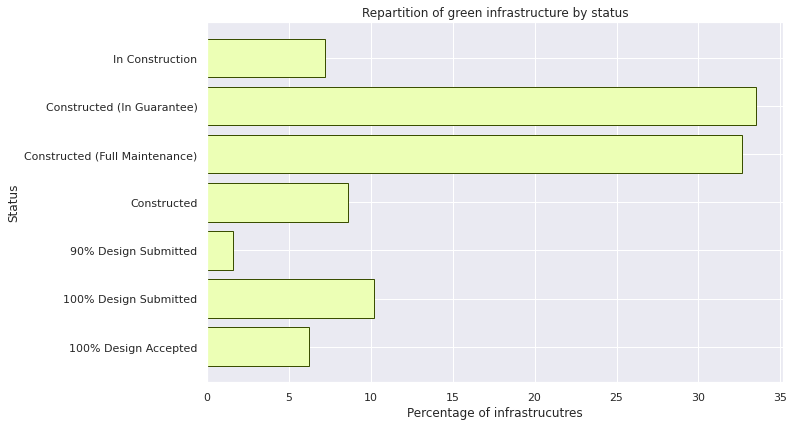

In [26]:
status = green_infra.Status.unique()

counts_stat = []
for stat in status:
    counts_stat.append(green_infra[green_infra.Status == stat].shape[0]/n_infra*100)

fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
ax.barh(status, counts_stat, color='#ecffb5', edgecolor='#3a4e01')
ax.set_ylabel('Status')
ax.set_xlabel('Percentage of infrastrucutres')
ax.set_title('Repartition of green infrastructure by status')
plt.show()

Over 70% of the green infrastructures have already been constructed, which could be explained by the fact that this incentive to green infrastructure dates back to 2014. However, new green infrastructures are also currently being planned or constructed.

In [ ]:
col_gi = ['#fde8ac','#eabb8c','#d29075','#b36865','#8e4459','#63264d','#33103f']
fig = px.scatter_mapbox(green_infra, lon="Longitude", lat="Latitude", 
                         opacity = 1, title="Statuses of green infrastructures", color="Status", color_discrete_sequence=[px.colors.sequential.matter_r[k] for k in [0,2,4,6,8,10,11]],
                         mapbox_style='carto-positron', zoom = 9, size = [1]*len(green_infra), size_max = 3)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

Most planned green infrastructures are located in Queens (for construction sites) and in Brooklyn (for design proposals).

### Community Gardens

In [ ]:
df5 = pd.read_csv('ARCHIVED_-_NYC_Greenthumb_Community_Gardens.csv')

fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           title = 'Community Gardens over Concentrated Poverty',
                           color_continuous_scale="matter",
                           range_color=(min_val, max_val),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Proportion of concentrated poverty',
                               'Location': 'District name'}
                          )

fig2 = px.scatter_mapbox(df5, lon="Longitude", lat="Latitude",
                         title = 'Community Gardens over Concentrated Poverty',range_color=(0, 100), opacity = 1,
                         color_discrete_sequence=['LightGreen'], size = [1]*len(df5), size_max = 3)
fig.add_trace(fig2.data[0])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

We can see that Community Gardens are strongly concentrated in poorer areas.

In [29]:
#Create heatmap for New York city Community Gardens
nyc = folium.Map([40.7128, -74.0060], tiles = "Stamen Toner", zoom_start=11)

#Get garden location data
garden_data = pd.read_csv('ARCHIVED_-_NYC_Greenthumb_Community_Gardens.csv')
garden_data_plottable = garden_data[garden_data['Latitude'].notnull()]
garden_data_plottable = garden_data_plottable[garden_data_plottable['Longitude'].notnull()]

#Create and plot points to create heatmap
heat_data = [[row['Latitude'],row['Longitude']] for index, row in garden_data_plottable.iterrows()]
HeatMap(heat_data, radius=13, blur=14, max_opacity=0.8).add_to(nyc)

#Display
nyc

This visualization shows the repartition of Community Gardens in a heatmap format.

### Gentrification factors

In this section, we chose to focus on a few different districts and compare factors and trends that could indicate gentrification. We chose the districts based off of where there were significantly high or low factors such as community gardens or green infrastructure so that we could see how gentrification interacts with these projects. We chose to look at Bed-Stuy and Williamsburg in Brooklyn, Mott Haven/Melrose in the Bronx and South Beach/Wilowbrook in Staten Island. The Staten Island choice was a sort of 'control' residential area that had relatively little change over time and the Bronx and Brooklyn neighborhoods were to analyze how the different areas have been impacted by gentrification because Brooklyn and the Bronx were found to be quite different in that regard. 

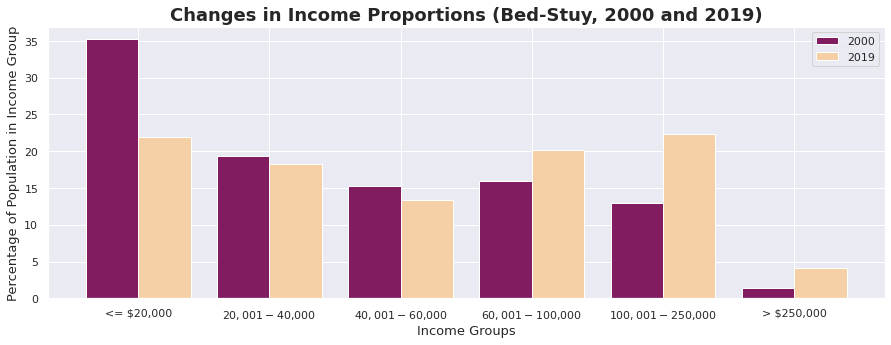

In [30]:
#Get data for specific district
income_data = pd.read_csv('income_distribution_data.csv')
X = ['<= $20,000','$20,001 - $40,000','$40,001 - $60,000','$60,001 - $100,000','$100,001 - $250,000','> $250,000']
val_2000 = income_data.iloc[40][4:10].values
val_2019 = income_data.iloc[41][4:10].values

#Change data to numerical format
for i in range(0,len(val_2000)):
    val_2000[i] = float(val_2000[i][:-1])

for i in range(0,len(val_2019)):
    val_2019[i] = float(val_2019[i][:-1])

#Customize plot to print multiple bars
X_axis = np.arange(len(X))
fig = plt.figure(figsize=(15,5))

#Draw Bars based on data
plt.bar(X_axis - 0.2, val_2000, 0.4, label = '2000', color = '#821c61')
plt.bar(X_axis + 0.2, val_2019, 0.4, label = '2019', color = '#f5cfa5')
  
#Customize and Print plot
plt.xticks(X_axis, X)
plt.xlabel("Income Groups", fontsize = 13)
plt.ylabel("Percentage of Population in Income Group", fontsize = 13)
plt.title("Changes in Income Proportions (Bed-Stuy, 2000 and 2019)", fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.legend()
plt.show()

From this graph we can conclude that salaries below 60,000 decreased, it is especially visible for salaries below 20,000 decreased by 30%. In parallel, the salaries above 60,000 increased : salaries between 100,000 and 250,000 increased by 30% and salaries above 250,000 were multiplied by 3. This is proof of gentrification of the area.

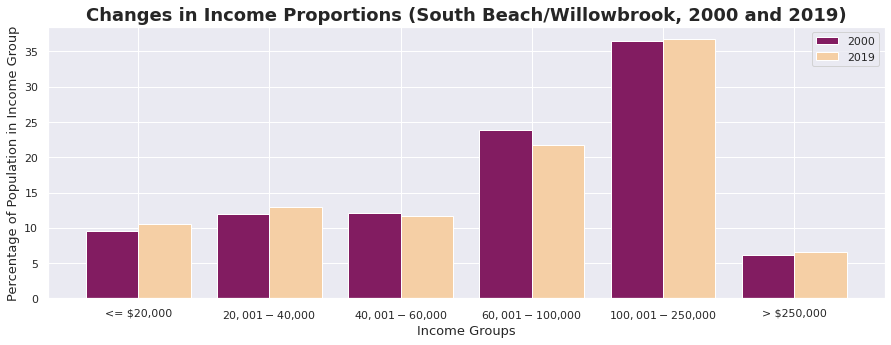

In [31]:
#Get data for specific district
X = ['<= $20,000','$20,001 - $40,000','$40,001 - $60,000','$60,001 - $100,000','$100,001 - $250,000','> $250,000']
val_2000 = income_data.iloc[126][4:10].values
val_2019 = income_data.iloc[127][4:10].values

#Change data to numerical format
for i in range(0,len(val_2000)):
    val_2000[i] = float(val_2000[i][:-1])

for i in range(0,len(val_2019)):
    val_2019[i] = float(val_2019[i][:-1])

#Customize plot to print multiple bars
X_axis = np.arange(len(X))
fig = plt.figure(figsize=(15,5))

#Draw Bars based on data
plt.bar(X_axis - 0.2, val_2000, 0.4, label = '2000', color = '#821c61')
plt.bar(X_axis + 0.2, val_2019, 0.4, label = '2019', color = '#f5cfa5')

#Customize and Print plot
plt.xticks(X_axis, X)
plt.xlabel("Income Groups", fontsize = 13)
plt.ylabel("Percentage of Population in Income Group", fontsize = 13)
plt.title("Changes in Income Proportions (South Beach/Willowbrook, 2000 and 2019)", fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.legend()
plt.show()

The phenomenon of gentrification is less obvious here.

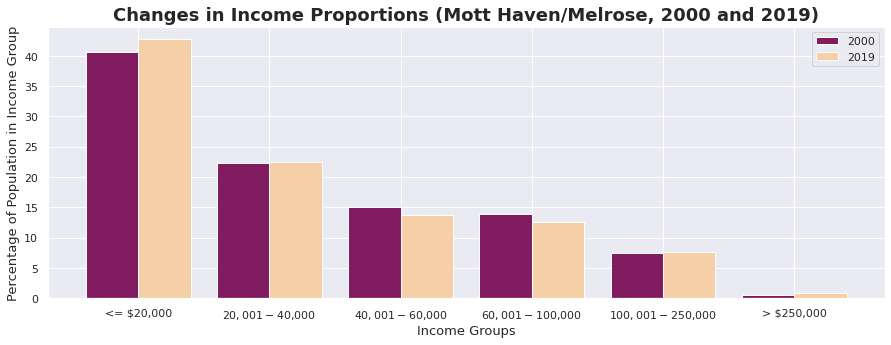

In [32]:
#Get data for specific district
X = ['<= $20,000','$20,001 - $40,000','$40,001 - $60,000','$60,001 - $100,000','$100,001 - $250,000','> $250,000']
val_2000 = income_data.iloc[12][4:10].values
val_2019 = income_data.iloc[13][4:10].values

#Change data to numerical format
for i in range(0,len(val_2000)):
    val_2000[i] = float(val_2000[i][:-1])

for i in range(0,len(val_2019)):
    val_2019[i] = float(val_2019[i][:-1])

#Customize Plot to get Multiple Bars
X_axis = np.arange(len(X))
fig = plt.figure(figsize=(15,5))

#Draw Bars based on data
plt.bar(X_axis - 0.2, val_2000, 0.4, label = '2000', color = '#821c61')
plt.bar(X_axis + 0.2, val_2019, 0.4, label = '2019', color = '#f5cfa5')
  
#Customize and Print plot
plt.xticks(X_axis, X)
plt.xlabel("Income Groups", fontsize = 13)
plt.ylabel("Percentage of Population in Income Group", fontsize = 13)
plt.title("Changes in Income Proportions (Mott Haven/Melrose, 2000 and 2019)", fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.legend()
plt.show()

This analysis was especially interesting because it showed that even though the Bronx and Brooklyn shared a lot of similarities in many of the early data maps, here was where they started to show clear distinctions. Whereas Brooklyn showed obvious signs of gentrification and rising housing and income levels, the Bronx stayed essentially the same across many of these levels. This showed that even though both areas had high poverty, Brooklyn was clearly going through a transformation in many respects. This became even more interesting when considering some of our early environmental data that showed differences between the Bronx and Brooklyn

In [33]:
def get_change(i2000, i2019):
    val_2000 = income_data.iloc[i2000][4:10].values
    val_2019 = income_data.iloc[i2019][4:10].values

    for i in range(0,len(val_2000)):
        val_2000[i] = float(val_2000[i][:-1])

    for i in range(0,len(val_2019)):
        val_2019[i] = float(val_2019[i][:-1])

    return val_2019 - val_2000

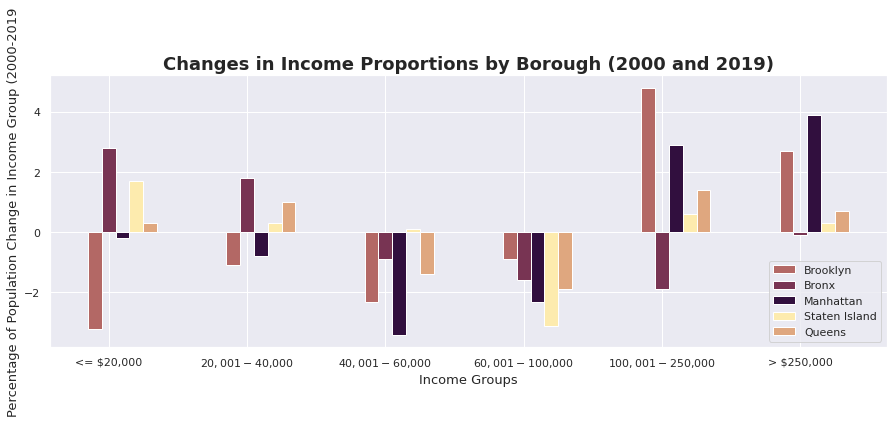

In [34]:
X = ['<= $20,000','$20,001 - $40,000','$40,001 - $60,000','$60,001 - $100,000','$100,001 - $250,000','> $250,000']

#Get Changes in Household Incomes for different Boroughs 2000-2019
change_bk = get_change(4,5)
change_bx = get_change(2,3)
change_q = get_change(8,9)
change_m = get_change(6,7)
change_s = get_change(10,11)
change_ny = get_change(0,1)

#Customize plot size to get multiple bars
ind = np.arange(len(X)) 
width = 0.20
fig = plt.figure(figsize=(15,5))

#plt.bar(ind + 0.1, change_bk, 0.1, label = 'Brooklyn', color = 'darkred')
#plt.bar(ind + 0.2, change_bx, 0.1, label = 'Bronx', color = 'orangered')
#plt.bar(ind + 0.3, change_m, 0.1, label = 'Manhattan', color = 'orange')
#plt.bar(ind + 0.4, change_s, 0.1, label = 'Staten Island', color = 'lightcoral')
#plt.bar(ind + 0.5, change_q, 0.1, label = 'Queens', color = 'mistyrose')

#Plot Bar chart for differences between households incomes 
plt.bar(ind + 0.1, change_bk, 0.1, label = 'Brooklyn', color = col_dic['Brooklyn'])
plt.bar(ind + 0.2, change_bx, 0.1, label = 'Bronx', color = col_dic['Bronx'])
plt.bar(ind + 0.3, change_m, 0.1, label = 'Manhattan', color = col_dic['Manhattan'])
plt.bar(ind + 0.4, change_s, 0.1, label = 'Staten Island', color = col_dic['Staten Island'])
plt.bar(ind + 0.5, change_q, 0.1, label = 'Queens', color = col_dic['Queens'])

#Customize Plot
plt.xticks(ind+width, X)
plt.xlabel("Income Groups", fontsize = 13)
plt.ylabel("Percentage of Population Change in Income Group (2000-2019", fontsize = 13)
plt.title("Changes in Income Proportions by Borough (2000 and 2019)", fontdict = {'fontsize': 18, 'fontweight' : 'semibold', 'fontfamily' : 'times new roman'})
plt.legend()
plt.show()

From this graph we can see that the most gentrified Boroughs are Manhattan and Brooklyn.

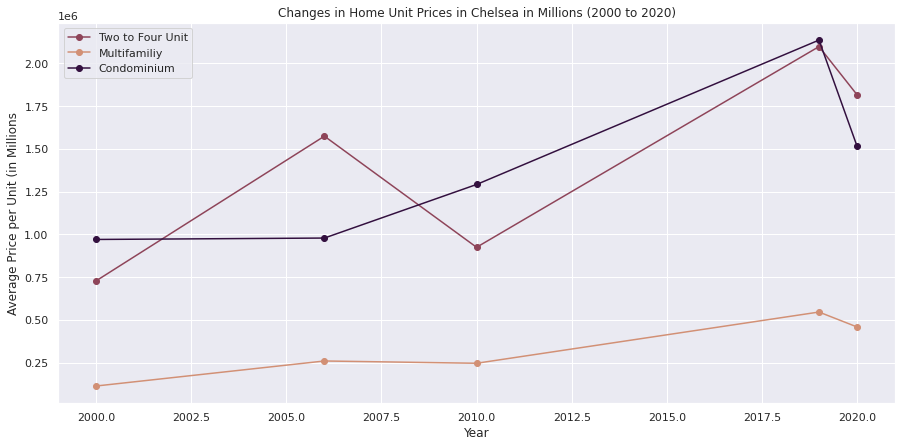

In [35]:
# Data from NYU Furman Center Neighborhood Profiles
# https://furmancenter.org/neighborhoods/view/clinton-chelsea
x = [2000,2006,2010,2019,2020]
y_two_unit = [728940, 1574360, 925000, 2097760, 1816520]
y_multi = [114420, 260660, 247320, 546690, 459520]
y_condo = [970800, 978990, 1292070, 2135910, 1516150]
markers_on = [2000, 2006, 2010, 2019, 2020]

# Plot different values on line chart
plt.plot(x, y_two_unit,'-o', label = "Two to Four Unit", color = '#8e4459')
plt.plot(x, y_multi,'-o', label = "Multifamiliy", color = '#d29075')
plt.plot(x, y_condo,'-o', label = "Condominium", color = '#33103f')
plt.xlabel("Year")
plt.ylabel("Average Price per Unit (in Millions")
plt.title("Changes in Home Unit Prices in Chelsea in Millions (2000 to 2020)")
plt.legend()
plt.show()

All types of Home Units in Chelsea faced an increased in prices : multifamilly ones were multiplied by 2, Condominium by 1.5 and Two to Four Unit by 2.3. This shows that gentrification in Chelsea affected all types of housing.

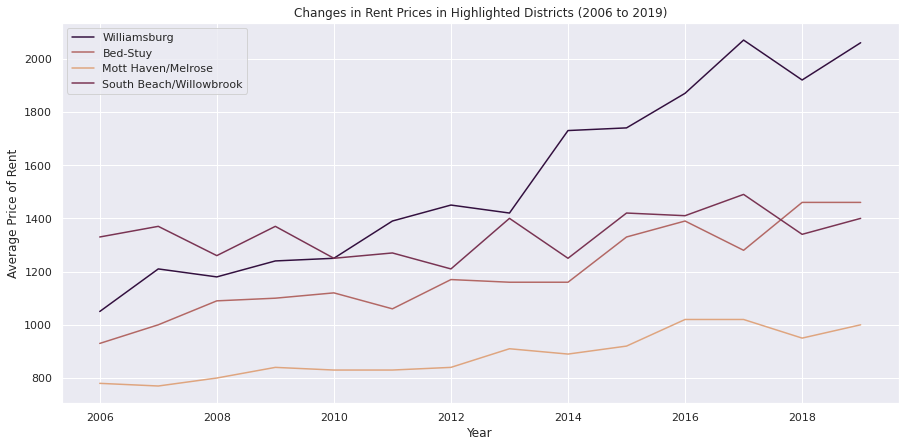

In [36]:
#Map rent levels for 4 different neighborhoods
rent_data = pd.read_csv('median_rent_data.csv')
x = list(range(2006,2020))

#Get rent values from the dataset for each neighborhood
y_bx01 = rent_data.iloc[6][3:17].values
y_bk01 = rent_data.iloc[18][3:17].values
y_bk03 = rent_data.iloc[20][3:17].values
y_s02 = rent_data.iloc[63][3:17].values

#Plot the values on a line chart
plt.plot(x, y_bk01, label = "Williamsburg", color = '#33103f')
plt.plot(x, y_bk03, label = "Bed-Stuy", color = '#b36865')
plt.plot(x, y_bx01, label = "Mott Haven/Melrose", color = '#dfa57f')
plt.plot(x, y_s02, label = "South Beach/Willowbrook", color = '#793453')
plt.xlabel("Year")
plt.ylabel("Average Price of Rent")
plt.title("Changes in Rent Prices in Highlighted Districts (2006 to 2019)")
plt.legend()
plt.show()

Except for South Beach/Willowbrook, Rent Prices increased significantly in all neighbourhoods. It is especially impressive for Williamsburg. This increase is a factor which shows the gentrification of the neighbourhoods.

# 4. Genre

As this subject is a complex social issue, we chose to use the Magasine Style. This is why our website contains a significant amount of text.

The most important category of **Visual Narrative** we used is the **Consistent Visual Platform**, we tried to use mostly the same color palette to keep the graphs visually coherent. Plus we used the same maps to be able to compare the visualizations. Then to highlight our data we used a **Feature Distinction** based on color : the green projects are represented in green while the social issues (Air Quality, Poverty, Income, Housing prices, ...) are in a gradient from purple to yellow. This way we can overlay both element without being confusing. Finally, we insured that a **Viewer (Camera) Motion** was possible on most graphs, which was possible for the maps. This way the viewer can explore our visualizations by themselves, which encourages participation in our observations.

Regarding **Narrative Structure**, as we wanted to tell a stories which goes from the most obvious element -Green Projects definitely have positive outcomes- to then dig deeper in the problem of Green Gentrification -as these projects improve the neighbourhood, some population could not afford to leave there anymore-. We want the reader to ask themselves about the potential hidden outcomes of green projects. This required a strong structure, which is why we chose a **Linear Ordering**. As our maps are highly interactive, we cover the **Hover Highlighting / Details** and **Navigation Buttons** categories of Interactivity. Finally, to show that green gentrification affects especially Hispanic Americans and Hispanic and explain the racial impact of green gentrification, we have an **Introductory Text** (and a Background section).


# 5. Visualizations

In our article we will develop the following structure

**1. Background**

In this section, we will first display the map of Borough to be able to locate each neighbourhood into a Borough. This will facilitate the analysis of more detailed maps.

Then we will display both the maps of Concentrated Poverty in 2010 and 2020 and the map of the rate of Hispanic American and African American population (separated and combined). We chose these plots to show that the Poverty and Race are correlated, and, as gentrification affects poorer neighbourhood, it is also a racial issue.

**2. Exploring the Positive Impacts of Sustainable Initiatives**
>* Improving Quality of Life and Environmental Benefits

For this section we will first plot the time series and the bar plot in the evolution of Air Pollution in the Boroughs, as well as the 2009 and 2020 Air Pollution maps. These two plots show that green incentives have indeed a positive effect on factors like Air Pollution.

Then we will give example of the Green Infrastructure with the Green Infrastructure interactive map and the Green Infrastructure Map (with completion status). We want to say that they are mostly located in Brooklyn and Queens, and that they are present in the Bronx but in a lesser extent. This shows that the poorest Borough does not have an equal access to these structures.

>*  Building a sense of Community 

For this section we will display the heatmap of Community Gardens and the Community Gardens Bar Plot. This shows that Community Gardens are concentrated in the poorer neighbourhoods.

**3. Taking a Deeper Look**
>* Gentrification 

For this section we will first display the changing in Income Levels in Boroughs, then the Bar Plots of Bed-Stuy and Mott Haven, the Bar Plot of Staten Island (South Beach) and the Line Chart with Rent Prices in the Districts. The goal is to show the concrete effects of gentrification in the affordability of the neighbourhoods. We want to show that if they are less affordable (if housing prices go up) then the poorer population will not be able to live there anymore and will have to move. This will induce a change in the ratio of different incomes in the neighborhoods.

**4. What Does This Mean? What is Environmental Injustice?**
We will display the Chelsea Housing Prices Over Time Line Graph and will give the example of the High Line. We want to explain the concrete impact of the high line in the housing prices to show the effects of green gentrification on poorer populations.


# 6. Discussion

We managed to find interesting datasets and to establish coherent links between them. We covered a wide scope on green gentrification thanks to the number of datasets we used. It was exciting going through datasets and seeing trends start to form and things we had read about and discussed be actually supported within the data. The connections between different datasets went well, however it was sometimes hard to find data that represented trends and phenomenon we read about and wrote about. For example, we knew about the High Line and its importance as a symbol of gentrication but adding a data analysis element to this more 'conversational' part of the report proved a little difficult with the data that we had available. 

We also saw some analysis that existed online (such as https://www.urbandisplacement.org/maps/new-york-gentrification-and-displacement/) that was fascinating and perfectly fit within our arguments. However, once again, it was hard to create our own data analysis from a source such as this, as the analysis part was essentially done and we would just be doing the same thing and the data was internally kept in many instances. 

Overall, in many cases the parts of our project that were the hardest or remained 'unfinished' were creating data visualizations and analysis for all the ideas we had and concepts we discussed, as it sometimes seemed like we had more to talk about than to actually show. 


Addtionally, one of the most important difficulties we had was with the file with the Energy Ratings. We thought it would be a center piece on showing the energetical inequalities poorer populations faces. However, we couldn't show any correlation between the two datasets. (A part of the analysis we carred out is present in the annexes).

# Contributions

>* id1 : ST48, Concentrated Poverty, Green Infrastructure, Web site coordination
>* id2 : ST204, Gentrification (Income, Housing Prices,...), Community Gardens, Web site text (story/narrative)
>* id3 : ST96, Air Quality, (Housing Energy Ratings), Green Streets, Community Gardens, Notebook Coordination

# References

https://www.urbandisplacement.org/maps/new-york-gentrification-and-displacement/
https://furmancenter.org/neighborhoods/view/clinton-chelsea
https://www1.nyc.gov/site/dep/about/strategic-plan.page
https://www.grownyc.org/gardens/our-community-gardens

# Annexe : Housing Energy Ratings

### Preprocessing

Text(0.5, 1.0, 'Letter Score repartition')

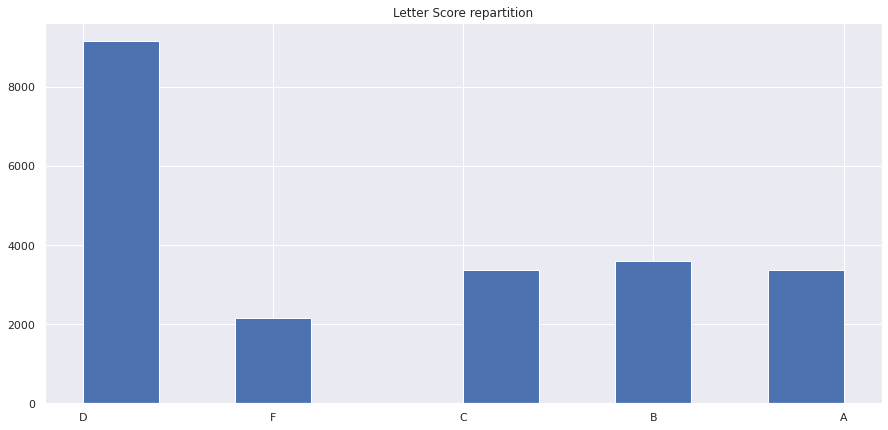

In [37]:
df1 = pd.read_csv('DOB_Sustainability_Compliance_Map__Local_Law_33.csv')
df1.LetterScore.hist()
plt.title('Letter Score repartition')

Most buildings in New York are poorly isolated and induce a high consumption of energy.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

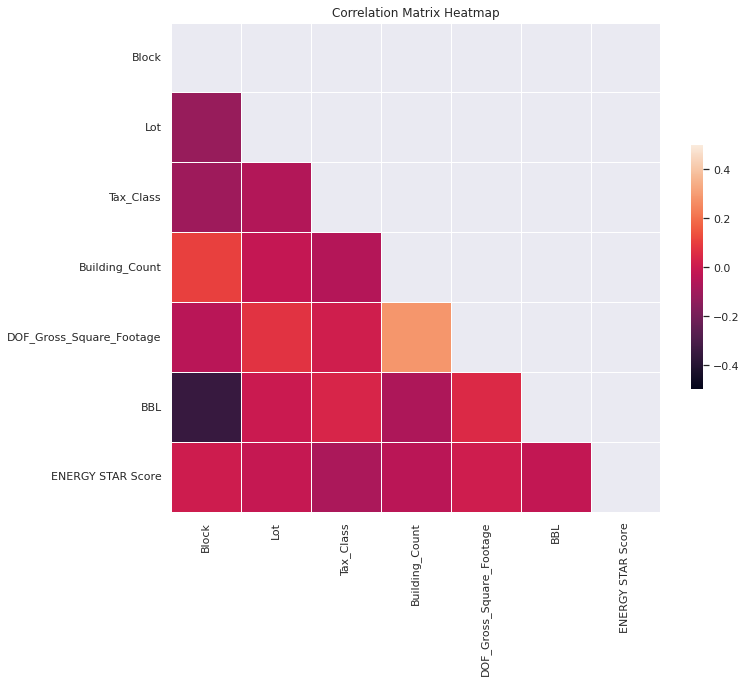

In [38]:
corr_matrix = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'rocket'

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix Heatmap')

The goal of this dataset was initially to try and predict the Energy Star Score given informations on the building (and Social Data), but as seen on the correlation matrix, the Energy Star Score doesn't seem to be correlated to any of these categories.

In [ ]:
# These calculations are very long, I strongly advise to avoid runnng them 
# (this is why the command print(key1) is here, to raise an error and not run the rest of the calculations)

# To be able to have Social Data added to informations on the building, we needed to obtain the neighbourhood
# in which the buildings are located

# We first use an API to get the latitude and longitude of the building, we will therefore be able to plot it on a map
key = '441374e737c621daebfe3117f959c75f'
print(key1) 

import requests

url = "http://api.positionstack.com/v1/forward"

params = {'access_key' : key, 'query' : '920 GRESHAM ROAD, New York'}

response = requests.request("GET", url, params=params)

lat = []
lon = []
NTA = []
count_done = 0
essai = [df1.Address[0]]

for a in df1.Address[13511:] : 
    lat_ok = False
    lon_ok = False
    NTA_ok = False
    
    try : 
        query = a + ', New York'
        params = {'access_key' : key, 'query' : query }
        response = requests.request("GET", url, params=params)
        result = response.json()
        dico = result['data'][0]
        lat += [dico['latitude']]
        lat_ok = True
        lon += [dico['longitude']]
        lon_ok = True
        NTA += [dico['neighbourhood']]
        NTA_ok = True
        count_done += 1
        
    except : 
        if lat_ok == False :
            lat += ['error']
            lon += ['error']
            NTA += ['error']
            
        elif lon_ok == False : 
            lon += ['error']
            NTA += ['error']
            
        elif NTA_ok == False :
            NTA += ['error']

lat2 = lat[:13510] + [dico['latitude']] + lat[13510:]
lon2 = lon[:13510] + [dico['longitude']] + lon[13510:]
NTA2 = NTA[:13510] + [dico['neighbourhood']] + NTA[13510:]

df1['latitude'] = lat2
df1['longitude'] = lon2
df1['NTA'] = NTA2

df1.to_csv('Buildings_withcoor.csv')

# As a lot of the neighbourhoods were missing, we tried using an additional file to extract the neighbourhood
# from the latitude and longitude
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
df = gpd.read_file('geo_export_e6a27b69-d4f3-413e-a9e3-b021db96c571.shp')

NTA = []

for _, row in df_missing.iterrows() :
    x = float(row['latitude'])
    y = float(row['longitude'])
    point = Point(y, x)
    
    found = False
    
    for _, row_geo in df.iterrows() : 
        if row_geo['geometry'].contains(point) :
            nbor = row_geo['ntaname']
            found = True
            
        if point.within(row_geo['geometry']) :
            nbor = row_geo['ntaname']
            found = True
            
        else : 
            try : 
                multi= row_geo['geometry'].next()
                if point.within(shape(multi['geometry'])):
                    nbor = row_geo['ntaname']
                    found = True
                    
            except : pass
            
    if not found : 
        nbor = 'error'
    
    NTA += [nbor]

df_missing['NTA'] = NTA
df_bis = df1[df1.NTA.notnull()].append(df_missing[df_missing.NTA != 'error'], ignore_index=True)
df_bis.to_csv('Buildings_withneigh.csv')

### Data Visualization

In [40]:
# Reading the calculated file and keeping the usable buildings
df1 = pd.read_csv('Buildings_withneigh.csv')
df1 = df1[(df1.latitude != 'error') & (df1.longitude != 'error')]
df1.latitude = df1.latitude.apply(float)
df1.longitude = df1.longitude.apply(float)

In [ ]:
#Plot the map
fig = px.choropleth_mapbox(data_2020, geojson=newyork_data, locations='Fips', color='Percent',
                           color_continuous_scale="matter",
                           range_color=(min_val, max_val),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 40.730610, "lon": -73.935242},
                           opacity=0.6,
                           hover_data=['Location', 'Percent'],
                           labels={
                               'Fips': 'District code',
                               'Percent': 'Proportion of concentrated poverty',
                               'Location': 'District name',
                           })

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig2 = px.scatter_mapbox(df1, lon="longitude", lat="latitude", color="ENERGY STAR Score",
                         range_color=(0, 100), opacity = 1)
fig.add_trace(fig2.data[0])

fig.layout.coloraxis2 = fig2.layout.coloraxis

fig['data'][1]['marker'] = {    'color' : np.array(df1['ENERGY STAR Score']),
                                    'coloraxis' : 'coloraxis2',
                                    'opacity' : 1,
                                    'sizemode' : 'area',
                                    'sizeref' : .01,
                                    'autocolorscale' : False
                                }

fig.update_geos(fitbounds="locations", visible=False)
fig.layout.coloraxis2.colorbar.x = -0.2

fig.show()

We expected lower ratings in poorer areas but it seems that there is no correlation between Poverty and Energy Star Score. We tried to predict the Energy Ratings adding other informations (Poverty, Community Gardens, Water Quality Data, ...) but obtained terrible results.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=403b3fec-1b07-4493-8eed-ae7ebeb55cd8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>